In [1]:

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sys
import os
import time

import archimedes as arc

# Add src to path
sys.path.insert(0, '..')

from src.core.state import State
from src.core.dynamics import AircraftDynamics
from src.core.integrator import RK4Integrator
from src.core.aerodynamics import LinearAeroModel
from src.core.propulsion import PropellerModel, CombinedForceModel


In [2]:

# ========================================
# Aircraft Parameters (from nTop UAV)
# ========================================
mass = 234.8  # slugs
inertia = np.array([
    [14908.4, 0, 0],
    [0, 2318.4, 0],
    [0, 0, 17226.9]
])  # slug·ft²

S_ref = 199.94  # ft²
c_ref = 26.689  # ft
b_ref = 19.890  # ft

print("Aircraft Parameters:")
print(f"  Mass: {mass:.1f} slugs ({mass * 32.174:.0f} lbm)")
print(f"  Wing area: {S_ref:.2f} ft²")
print(f"  Wing span: {b_ref:.2f} ft")
print(f"  Mean chord: {c_ref:.2f} ft")
print()

# ========================================
# Create Models
# ========================================

# Dynamics
dynamics = AircraftDynamics(mass, inertia)

# Aerodynamics - linear model with reasonable derivatives
aero = LinearAeroModel(S_ref, c_ref, b_ref, rho=0.002377)
# Tuned for stable flight
aero.CL_0 = 0.2
aero.CL_alpha = 4.5
aero.CD_0 = 0.03
aero.CD_alpha2 = 0.8
aero.Cm_0 = 0.0
aero.Cm_alpha = -0.6  # Stable
aero.Cm_q = -8.0      # Pitch damping

# Propulsion - 50 HP propeller
propulsion = PropellerModel(power_max=50.0, prop_diameter=6.0,
                                prop_efficiency=0.75)

# Combined force model
force_model = CombinedForceModel(aero, propulsion)

print("Models created:")
print("  - Linear aerodynamic model (stability derivatives)")
print("  - Propeller model (50 HP)")
print()

# ========================================
# Initial Conditions
# ========================================

state0 = State()
state0.position = np.array([0.0, 0.0, -5000.0])  # 5000 ft altitude, NED
state0.velocity_body = np.array([200.0, 0.0, 0.0])  # 200 ft/s forward
state0.set_euler_angles(0, np.radians(3), 0)  # 3° pitch for climb
state0.angular_rates = np.array([0.0, 0.0, 0.0])

print("Initial Conditions:")
print(f"  Position: {state0.position} ft (NED)")
print(f"  Altitude: {state0.altitude:.0f} ft")
print(f"  Airspeed: {state0.airspeed:.1f} ft/s")
print(f"  Pitch: {np.degrees(state0.euler_angles[1]):.1f}°")
print()

# ========================================
# Simulation Setup
# ========================================

dt = 0.01  # 10 ms time step
t_final = 30.0  # 30 seconds

integrator = RK4Integrator(dt=dt)

# Throttle schedule
throttle = 0.8  # 80% throttle


Aircraft Parameters:
  Mass: 234.8 slugs (7554 lbm)
  Wing area: 199.94 ft²
  Wing span: 19.89 ft
  Mean chord: 26.69 ft

Models created:
  - Linear aerodynamic model (stability derivatives)
  - Propeller model (50 HP)

Initial Conditions:
  Position: [    0.     0. -5000.] ft (NED)
  Altitude: 5000 ft
  Airspeed: 200.0 ft/s
  Pitch: 3.0°



## Native Python

In [3]:

# integrator = RK4Integrator(dt=dt)

# # Throttle schedule
# throttle = 0.8  # 80% throttle

# # Create derivative function with throttle
# def derivative_func(s):
#     return dynamics.state_derivative(s, lambda st: force_model(st, throttle))

# print(f"Simulation Parameters:")
# print(f"  Time step: {dt*1000:.1f} ms")
# print(f"  Duration: {t_final:.1f} seconds")
# print(f"  Throttle: {throttle*100:.0f}%")
# print()

In [4]:
# %%timeit
# t_hist, x_hist = integrator.integrate(state0, (0, t_final), derivative_func)

## Archimedes simulation

In [19]:
x0_flat, unravel_x = arc.tree.ravel(state0)

print(x0_flat)
print(unravel_x(x0_flat))

# Create derivative function with throttle
@arc.compile
def derivative_func(t, s_flat):
    s = unravel_x(s_flat)
    sdot = dynamics.state_derivative(s, lambda st: force_model(st, throttle))
    return arc.tree.ravel(sdot)[0]

print(f"Simulation Parameters:")
print(f"  Time step: {dt*1000:.1f} ms")
print(f"  Duration: {t_final:.1f} seconds")
print(f"  Throttle: {throttle*100:.0f}%")
print()

# ========================================
# Run Simulation
# ========================================
# 

rtol = 1e-3
atol = 1e-6
t_hist = np.arange(0, t_final, dt)

[ 0.00000000e+00  0.00000000e+00 -5.00000000e+03  2.00000000e+02
  0.00000000e+00  0.00000000e+00  9.99657325e-01  0.00000000e+00
  2.61769483e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
6-DOF Aircraft State:
  Position (NED):   [     0.0,      0.0,  -5000.0] ft
  Altitude:           5000.0 ft
  Velocity (body):  [ 200.00,    0.00,    0.00] ft/s
  Airspeed:          200.00 ft/s
  Euler angles:     [  0.00,   3.00,   0.00] deg
  Alpha, Beta:      [  0.00,   0.00] deg
  Angular rates:    [ 0.0000,  0.0000,  0.0000] rad/s
Simulation Parameters:
  Time step: 10.0 ms
  Duration: 30.0 seconds
  Throttle: 80%



In [21]:
derivative_func(0, x0_flat)  # Check first call works

array([ 1.99725907e+02,  0.00000000e+00,  1.04671912e+01, -2.54695087e+00,
        0.00000000e+00, -4.02262845e+01,  1.10984258e-16,  0.00000000e+00,
        2.90622507e-18,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00])

In [ ]:
%%timeit
# Time with recompilation
x_hist = arc.odeint(derivative_func, (0.0, t_final), x0_flat, t_eval=t_hist, rtol=rtol, atol=atol)
x_hist = x_hist.T

In [14]:
@arc.compile
def forward(x0_flat):
    return arc.odeint(derivative_func, (0.0, t_final), x0_flat, t_eval=t_hist, rtol=rtol, atol=atol)

# Run once to compile
x_hist = forward(x0_flat)
x_hist = x_hist.T

In [15]:
%%timeit
# Time without recompilation
x_hist = forward(x0_flat)

18.7 ms ± 547 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Final State:
  Position: [1533.0, -0.0, -4507.1] ft (NED)
  Altitude: 4507 ft (change: -493 ft)
  Airspeed: 39.5 ft/s (change: -160.5 ft/s)
  Pitch: 85.5° (change: +82.5°)
  Alpha: -58.5°

Generating plots...


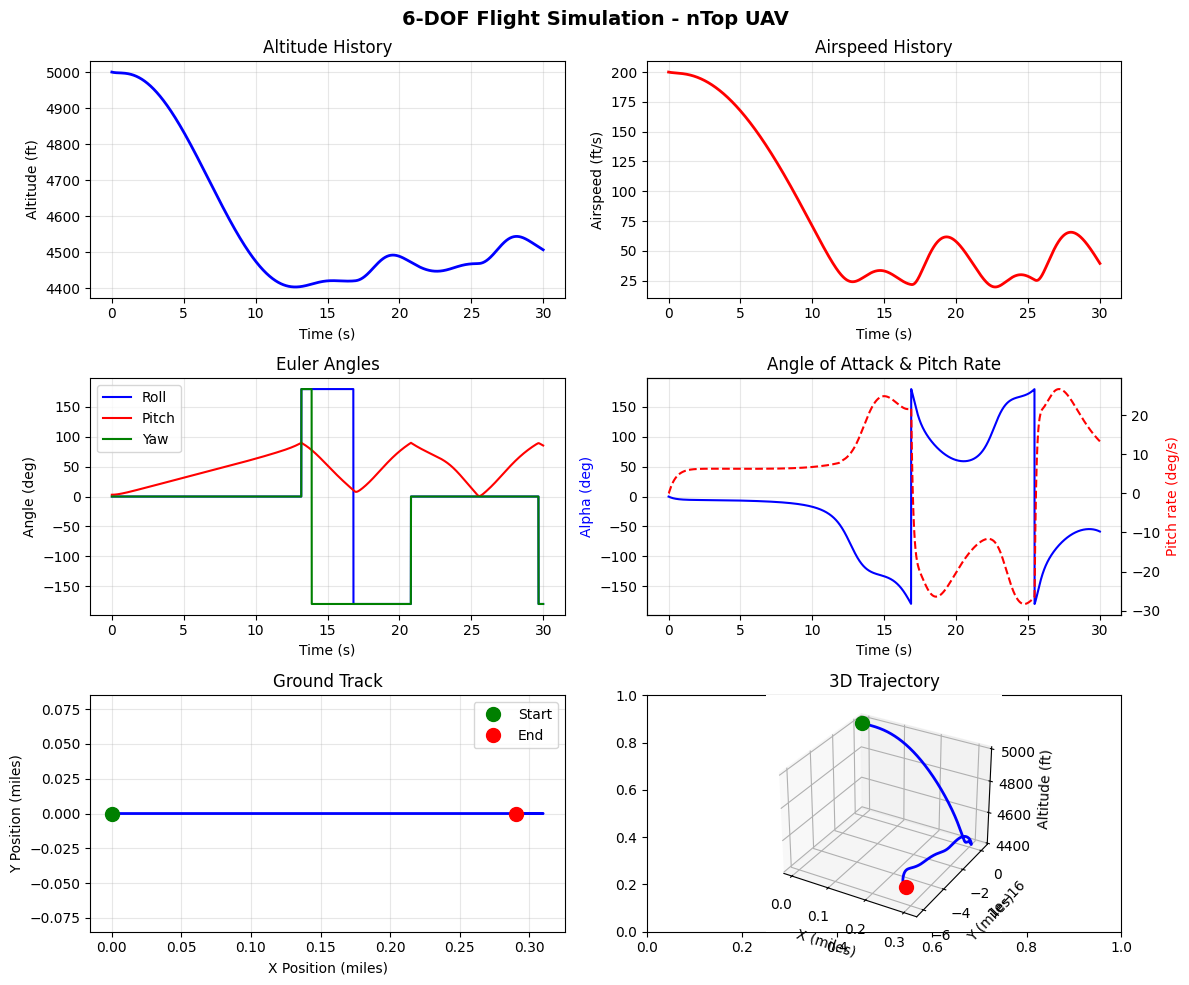

In [16]:

# ========================================
# Extract Results
# ========================================

n_steps = len(t_hist)
altitude = np.zeros(n_steps)
airspeed = np.zeros(n_steps)
pitch = np.zeros(n_steps)
roll = np.zeros(n_steps)
yaw = np.zeros(n_steps)
alpha = np.zeros(n_steps)
x_pos = np.zeros(n_steps)
y_pos = np.zeros(n_steps)
pitch_rate = np.zeros(n_steps)
q_norm = np.zeros(n_steps)

for i in range(n_steps):
    state_i = State()
    state_i.from_array(x_hist[i, :])
    q_norm[i] = np.linalg.norm(state_i.q.q)

    altitude[i] = state_i.altitude
    airspeed[i] = state_i.airspeed
    euler = state_i.euler_angles
    roll[i] = np.degrees(euler[0])
    pitch[i] = np.degrees(euler[1])
    yaw[i] = np.degrees(euler[2])
    alpha[i] = np.degrees(state_i.alpha)
    x_pos[i] = state_i.position[0]
    y_pos[i] = state_i.position[1]
    pitch_rate[i] = np.degrees(state_i.angular_rates[1])

# ========================================
# Display Final State
# ========================================

state_final = State()
state_final.from_array(x_hist[-1, :])

print("Final State:")
print(f"  Position: [{x_pos[-1]:.1f}, {y_pos[-1]:.1f}, {state_final.position[2]:.1f}] ft (NED)")
print(f"  Altitude: {altitude[-1]:.0f} ft (change: {altitude[-1] - altitude[0]:+.0f} ft)")
print(f"  Airspeed: {airspeed[-1]:.1f} ft/s (change: {airspeed[-1] - airspeed[0]:+.1f} ft/s)")
print(f"  Pitch: {pitch[-1]:.1f}° (change: {pitch[-1] - pitch[0]:+.1f}°)")
print(f"  Alpha: {alpha[-1]:.1f}°")
print()

# ========================================
# Plot Results
# ========================================

print("Generating plots...")

fig, axes = plt.subplots(3, 2, figsize=(12, 10))
fig.suptitle('6-DOF Flight Simulation - nTop UAV', fontsize=14, fontweight='bold')

# Altitude
axes[0, 0].plot(t_hist, altitude, 'b-', linewidth=2)
axes[0, 0].set_xlabel('Time (s)')
axes[0, 0].set_ylabel('Altitude (ft)')
axes[0, 0].set_title('Altitude History')
axes[0, 0].grid(True, alpha=0.3)

# Airspeed
axes[0, 1].plot(t_hist, airspeed, 'r-', linewidth=2)
axes[0, 1].set_xlabel('Time (s)')
axes[0, 1].set_ylabel('Airspeed (ft/s)')
axes[0, 1].set_title('Airspeed History')
axes[0, 1].grid(True, alpha=0.3)

# Euler angles
axes[1, 0].plot(t_hist, roll, 'b-', label='Roll', linewidth=1.5)
axes[1, 0].plot(t_hist, pitch, 'r-', label='Pitch', linewidth=1.5)
axes[1, 0].plot(t_hist, yaw, 'g-', label='Yaw', linewidth=1.5)
axes[1, 0].set_xlabel('Time (s)')
axes[1, 0].set_ylabel('Angle (deg)')
axes[1, 0].set_title('Euler Angles')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Alpha and pitch rate
axes[1, 1].plot(t_hist, alpha, 'b-', label='Alpha', linewidth=1.5)
ax2 = axes[1, 1].twinx()
ax2.plot(t_hist, pitch_rate, 'r--', label='Pitch rate', linewidth=1.5)
axes[1, 1].set_xlabel('Time (s)')
axes[1, 1].set_ylabel('Alpha (deg)', color='b')
ax2.set_ylabel('Pitch rate (deg/s)', color='r')
axes[1, 1].set_title('Angle of Attack & Pitch Rate')
axes[1, 1].grid(True, alpha=0.3)

# Ground track
axes[2, 0].plot(x_pos / 5280, y_pos / 5280, 'b-', linewidth=2)
axes[2, 0].plot(x_pos[0] / 5280, y_pos[0] / 5280, 'go', markersize=10, label='Start')
axes[2, 0].plot(x_pos[-1] / 5280, y_pos[-1] / 5280, 'ro', markersize=10, label='End')
axes[2, 0].set_xlabel('X Position (miles)')
axes[2, 0].set_ylabel('Y Position (miles)')
axes[2, 0].set_title('Ground Track')
axes[2, 0].legend()
axes[2, 0].grid(True, alpha=0.3)
axes[2, 0].axis('equal')

# 3D trajectory
ax3d = fig.add_subplot(3, 2, 6, projection='3d')
ax3d.plot(x_pos / 5280, y_pos / 5280, altitude, 'b-', linewidth=2)
ax3d.plot([x_pos[0] / 5280], [y_pos[0] / 5280], [altitude[0]], 'go', markersize=10)
ax3d.plot([x_pos[-1] / 5280], [y_pos[-1] / 5280], [altitude[-1]], 'ro', markersize=10)
ax3d.set_xlabel('X (miles)')
ax3d.set_ylabel('Y (miles)')
ax3d.set_zlabel('Altitude (ft)')
ax3d.set_title('3D Trajectory')

plt.tight_layout()